Copyright Amazon.com, Inc. or its affiliates. All Rights Reserved.
SPDX-License-Identifier: Apache-2.0

# How to utilize the GameTech Cohort Modeler

This notebook shows how to use the GameTech Cohort Modeler. The code sample provided with the GameTech Cohort Modeler will deploy an Amazon Neptune database and a set of APIs that utilize Gremlin to construct a knowledge graph for a games customer based on structured and non-structed data from [AWS Labs](#).
  
  - [Background](#Background)
  - [Getting Started](#Getting-Started)
  - [Cohort Modeler Data Model](#Cohort-Modeler-Data-Model)
  - [Basic CRUD Operations](#Basic-CRUD-Operations)
  - [Traversing The Graph](#Traversing-the-Graph)
  - [Graph Based Predictive Queries](#Graph-Based-Predictive-Queries)
  - [Conclusion](#Conclusion)
  
## Background

The GameTech Cohort Modeler is based upon the concepts of modern knowledge graphs and are the result of connections of data from multiple different sources. These sources can either be multiple different databases, different data silos, or data extracted from within entities stored in one or more of these options. Knowledge graphs come in many different forms but the unifying aspect of them is that they organize data using the entities and connections (known as semantics) familiar to a particular domain.  It represents these semantics as definitions of concepts, their properties, relations between them, and the expected logical constraints. Logic built into such a model allows us to infer understanding and connections about the information contained within the model.

With the GameTech Cohort, we have aimed to consolidate and integrate player data, relationships between players, the activities they engage in, and the marketing campaigns they interact with. With the API set created within the GameTech Cohort Modeler we operationalize the ability to visualize and query on these relationships to answer with data that was previously not queryable. 

The examples in this use case show how we can use the Cohort Modeler to demonstrate how we can use the connected nature of our knowledge graph to provide contextually relevant answers to search questions.

## Getting Started

The dataset used in this notebook was sythensized to recreate the needs of a mid-size game development studio that would be tracking metrics across ingame behaviors, player session length, and marketing campaign data.  This dataset contains individual player profiles with a unique UUID to represent a player across multiple platforms, as well as marketing camapaigns that have engaged with the user. To make the data set more realistic, we have added additional features to this data using the [python faker](https://faker.readthedocs.io/en/master/) library and Numpy to simulate standard distributions.  We have created a datamodel that will be flexible enough for customers to extend as needed. A graphical representation of the datamodel can be seen in the following image:

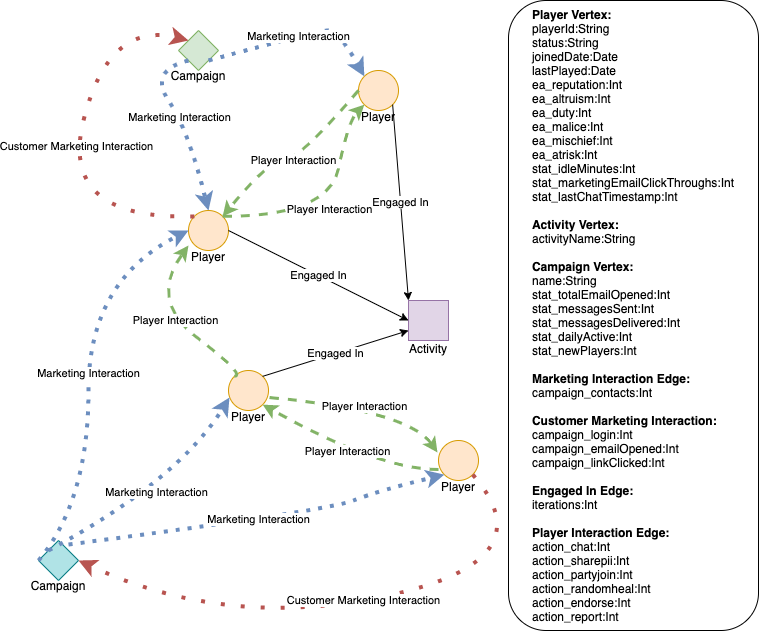

This data model could be used as the starting point for your own cohort model. In most cases, a studio will have data related to ingame actions, marketing campaigns, transactional data, session data, player technical data and other relevant business or telemetry data information. Users in this data model are represented with a UUID. There are some cases in which you may need to merge two users together as they are the same player playing on different platforms. We have assumed here that the data set provided has already gone through and merged all of the known like profiles together and we are storing relationships between users. 

***There is a process called [identity (or entity) resolution](https://en.wikipedia.org/wiki/Record_linkage#Entity_resolution) that you will need to go through to merge the two. The process of identity resolution can involve both deterministic patterns (such as matching users coming from the same public IP address within a certain time frame) or through more probabilistic means (using machine learning).***

***If your studio currently does not capture some or all of the data you would like to see represented on the graph you can take a look at the [Serverless Analytics Solution](https://docs.aws.amazon.com/solutions/latest/game-analytics-pipeline/architecture.html).*** 


## Cohort Modeler Data Model

**Vertexes** should contain *aggregate* data relevant to the vertex type

**Player vertices** should be expected to contain aggregate behavioral data, including community engagement, financial engagement, marketing campaign engagement and so forth. They should also be expected to contain a unique GUID that allows a deeper dive into player data by following that GUID to a DynamoDB record which will expose all relevant data in detail, rather than in aggregate.

**Activity vertices** should be expected to contain the metadata which defines how to alter the behavioral profile of a player who engages in the activity. For instance, if ‘spamming’ were to be rated at a +1 to mischief on a player profile, we’d note that on the SPAM Vertex.

**Marketing vertices** should be expected to contain aggregate data about the campaign, updated on a regular basis. Data items like DAU/MAU and others (covered later on in the example data model) would be noted and updated from a Pinpoint analytics stream on a regular scheduled basis. Again, a GUID should be expected here as well, so specific detailed information pertaining to the campaign could be located in a DynamoDB record.

**Edges** contain only the data describing *interactions* between two vertexes, and the direction of the edge should accurately indicate the originator and the target of the activity.

**Edges between Players and Players**: Bidirectional edges between players should be expected, as interactions between players will never be symmetrical. In some cases, we’ll see unidirectional edges when one player refuses to engage with another, but usually there should be some indication as to why (Player A whispers Player B, and then Player B files a harassment report - we now have bidirectional edges between the two).

**Edges between Players and Activities**: In most cases, unidirectional edges are to be expected since players engage in activities, but activities do not solicit players. That said, Bidirectional edges between players and activities could be useful when a game supports mechanisms to direct players to engage in those activities, like recommendation engines. 

**Edges between Players and Campaigns**: Bidirectional edges between players and marketing campaigns can be expected when those campaigns are targeted at explicit cohorts and not at the global player base. An edge out to a player from a campaign would include the number of times the targeted player was sent communications and via which channels.

### Checking to see if we have a connection to the Neptune Database
The %status command will let you know the health of your Neptune Graph Database Cluster and the supporting library versions installed.

In [ ]:
%status

### Checking what graph notebook version is currently running
The %graph_notebook_version command will return the graph notebook version software running in this notebook.

In [ ]:
%graph_notebook_version

### Loading the Identity Graph

To get started with the GameTech Cohort Modeler, we will load a set of data from the data model shown above into our Neptune cluster.  Run the following two cells to download and load this data.  It will take approximately 5-6 minutes to complete this next step.  ***This will load approximately 12,000 player profiles, campaigns and activites with their corresponding data.*** 

Currently we are creating sample data within a second notebook titled "CohortModelerDataGenerator" which should have come with the code sample. Start there and upload the data set to S3 before you move on in this notebook.

If using the data gen script you will want to load user_vertices.csv, campaign_vertices.csv, action_vertices.csv, interaction_edges.csv, engagement_edges.csv, campaign_edges.csv, and campaign_bidirectional_edges.csv in that order. If you run into an issue with the bulk loader, take a look at the [AWS documentation for trouble shooting](https://docs.aws.amazon.com/neptune/latest/userguide/load-api-reference.html)

In [ ]:
%seed --model Property_Graph --dataset cohort_modeler --run

## Basic CRUD Operations
To start off with we will have four basic CRUD operations showcasing how to create a new vertex or edge.

### Create Vertex
Creating a player node is done by using the addV method and the value passed is the label for the new vertex. The properties that we need to add are an ID which should ascribe to a unique GUID id. You can add more values associated values you want to contain on the vertex within the property feild in a key value pair if needed.

**To add different vertices for Activities and Campaigns you would replace the 'player' label with the label you want for the vertex.**

In [ ]:
%%gremlin
g.addV('player').property(id, 'newplayer1').next()

### Read the Values on a Target Vertex

In [ ]:
%%gremlin
g.V('newplayer1').elementMap().toList()

### Updating Values on Vertices
Vertices have values corresponding to a particular play which correspond to data that is either an emergent action or a statistic. Emergent actions such as altruism, malice, mischief and duty will all need to be incremented or decremented based upon a previous value. Gremlin has no increment feature and requires a unique query to read a value and increment from a previous value rather than overwrite the current value. This can be seen in the following query incrementing the value by 1.

In [ ]:
%%gremlin
g.V('newplayer1').
  property(
    single,
    'ae_altruism',
    union(values('ae_altruism'), constant(1)).sum()).
  valueMap()

### Create a second player

In [ ]:
%%gremlin
g.addV('player').property(id, 'newplayer2').next()

### Creating an Edge Between Two Vertices
To create an edge between two vertices you will need to know the GUIDs of each vertex. When creating an edge you ahve the ability to set values on the edge based upon the action taken. In the case of the following command we are creating an edge with single chat value of 1.

In [ ]:
%%gremlin
g.V('newplayer1').
  addE('interaction_edge').to(V('newplayer2')).
  property('chat', 1).
  next()

### Create an edge in the opposite direction


In [ ]:
%%gremlin
g.V('newplayer2').
  addE('interaction_edge').to(V('newplayer1')).
  property('chat', 1).
  next()

### Reading the Values on an Edge (Unidirectional)
~~Edges in the Cohort Modeler can be bidirectional or unidirectional. To read a single edge moving out from a target vertex you would use the following query.~~

In [ ]:
%%gremlin
g.V('newplayer1').outE('interaction_edge').elementMap()

### Reading the Values on an Edge (Bidirectional)

In [ ]:
%%gremlin
g.V('newplayer1').bothE('interaction_edge').elementMap()

### Reading the value between two targeted players

In [ ]:
%%gremlin
g.V('newplayer1').
  bothE('interaction_edge').
  where(otherV().hasId('newplayer2')).
  elementMap()

### Updating a Value on an Edge
Similar to vertices, edges have the ability to store values and a specific query is needed to increment a value from a previously stored value. 

In [ ]:
%%gremlin
g.V('newplayer1').
  outE('interaction_edge').
  where(inV().hasId('newplayer2')).
  property(
    'action_sharepii',
    union(values('action_sharepii'), constant(1)).sum()).
  valueMap()

### Dropping an Edge Between Two Vertices
To drop an edge between two vertices you will need to know the GUID ID of both vertices. The resulting command will drop all the values stored on the edge.

In [ ]:
%%gremlin
g.V('newplayer1').bothE().where(otherV().is('newplayer2')).drop()

### Delete Vertex
To drop a vertex. Place the ID of the vertex in the following command and run. When running this command this will also destroy the edges and the values interacting to and from the targeted vertex. All adjacent edges are dropped as well.

In [ ]:
%%gremlin
g.V("newplayer1").drop()

## Traversing the Graph
Now that we have a number of basic queries for creating and reading values from vertices and edges. With the Cohort Modeler constructs we can query to find groupings of players who are interacting with each other and investigate unique relationships between players, activites, and campaigns to get a better understand how to group and view like player interactions.

### Visualizing First Order Relationships
Find users that a given user's unique GUID has Interaction edges out. This query will return all the edges and the vertices that the edges are connected to and return back a graph visualization.

In [ ]:
%%gremlin -d ea_altruism
g.V('237c54a8-20b6-46a2-aef8-0b2fb105d3cc').
  outE('interaction_edge').
  inV().
  path().by(elementMap())

### Visualizing Second Order Relationships
Find users that a given user's unique GUID has Interaction edges out and the edges of out of the players returned. This query will return all the edges and the vertices that the edges are connected to and return back a graph visualization.

In [ ]:
%%gremlin -p v,oute,inv,oute,inv
g.V('237c54a8-20b6-46a2-aef8-0b2fb105d3cc').
  outE('interaction_edge').
  inV().
  outE('interaction_edge').
  inV().
  path().by(id()).by(label)

### Visualizing Third Order Relationships
Find users that a given user's unique GUID has Interaction to the players that the players that the player queried interacted with. This query will return all the edges and the vertices that the edges are connected to and return back a graph visualization.

In [ ]:
%%gremlin -p v,oute,inv,oute,inv,oute,inv -sd 50000
g.V('237c54a8-20b6-46a2-aef8-0b2fb105d3cc').
  outE('interaction_edge').
  inV().
  outE('interaction_edge').
  inV().
  outE('interaction_edge').
  inV().
  path().by(id()).by(label)

# Graph Based Predictive Queries 

###  Indirect related players (Triadic Closure)

Find users that a given user has not directly interacted with, but that they might want to interact with based on common interactions. This query looks at players with similar player behavior to recommend people the player may want to interact with further.

In [ ]:
%%gremlin 
g.V('237c54a8-20b6-46a2-aef8-0b2fb105d3cc').as('user').out('interaction_edge').aggregate('friends').
    out('interaction_edge').
    where(neq('user')).where(without('friends')).
    groupCount().by(id()).order(local).by(values,desc).unfold()

### Collaborative Triadic Closure Query


Graph allows us to query based upon the emergent actions to find collaborative bad actors or find rings of bad actors. The players returned by this query may require additional monitoring resources from community based tools.


In [ ]:
%%gremlin
g.V('237c54a8-20b6-46a2-aef8-0b2fb105d3cc').
  out('interaction_edge').
  where(
    out('action_edge').
    hasId('action_sharepii').
    in('action_edge').
    hasId('237c54a8-20b6-46a2-aef8-0b2fb105d3cc'))

### Bad Actors Query

This query will find players that have a reputation of 0 and return back all of the players that interacted with them. Similar to the previous query this query allows you to monitor how these players are interacting with the community at large and the players impact on other players.

In [ ]:
%%gremlin -d ea_reputation

g.V().hasLabel('player').has('ea_reputation', lt(-75)).aggregate('starting_player').
    out('interaction_edge').
    where(
        outE('interaction_edge').
        has('action_sharepii').
        inV().
        in('interaction_edge').
        where(within('starting_player'))
    ).
    as('related_player').path().by(elementMap())

### Find all users related based on Interactions and Bad Actions

In [ ]:
%%gremlin -p v,oute,outv,oute,outv,ine,inv

g.V().hasLabel('player').
    has('ea_reputation',lt(0)).as('starting_player').
        outE('interaction_edge').inV().outE('action_edge').inV().
        hasId('action_report','action_badimage','action_badlanguage','action_badname','action_sharepii').
        inE('action_edge').outV().
    //where(is(eq('starting_player'))).  # come back to starting point
    path().by(id()).by(label)

## Conclusion

The Cohort Modeler will be a key component in analyizing a games studious customer behaviors and providing deeper insights to microtarget future development, marketing campaigns, player behavior tools and other actions toward a subset of users that will maximize the value within a games community and future. In this notebook, we went through the data model, basic CRUD operations, graph traversals, and advanced graph queries to begin to have a deeper understanding of a games community and the basis potential use cases for future applications derived from the data contained in the Cohort Modeler. The examples contained in this notebook are just a small subset of how the Cohort Modeler can be utilized.
